In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path
from os import path
import math
import heartpy as hp
from scipy.stats import mode

In [17]:
PARTICIPANT = "participant_8"

## Log Reg

## RF

## SVM

## NN if needed

In [18]:
###########################
## Load or Compile Files ##
###########################

if path.exists("data/saved/" + PARTICIPANT):
    ## Read in already saved dataframe
    print("file data already extracted, opening...")
    data = pd.read_pickle("data/saved/" + PARTICIPANT)
    print("successfully opened")
    pass

else:
    print("compiling individual data files...")

    ## Collect each mini .csv file to a df
    individual_dfs = []
    for f in os.listdir("data/raw/" + PARTICIPANT):
        small_df = pd.read_csv("data/raw/"+ PARTICIPANT + "/" + f, header=0)
        individual_dfs.append(small_df)

    ## Put these dfs together
    data = pd.concat(individual_dfs, axis=0)

    ## Format the time correctly
    data["time"] = data['year'].astype(str) + "-" + data['month'].astype(str) + "-" + data['day'].astype(str) + " " + data['hour'].astype(str) + "-" + data['minute'].astype(str) + "-" + data['second'].astype(str)
    data = data.drop(["id", "year", "month", "day", "hour", "minute", "second"], axis=1)
    data = data.set_index("time")

    ## Sort by time
    data = data.sort_index()

    ## Filter IR to BVP with a highpass filter
    data['ir'] = hp.filter_signal(data["ir"], cutoff = 0.75, sample_rate = 100.0)
    data.rename(columns = {'ir':'bvp'}, inplace = True)

    ## Smooth pump and vacuum labels
    data['pump_on'] = data['pump_on'].rolling(10, center=True).apply(lambda x: mode(x)[0])
    data['vacuum_on'] = data['vacuum_on'].rolling(10, center=True).apply(lambda x: mode(x)[0])

    ## Fill the first 9 values with the same as value 10 to get rid of the nan, unless you do the first 5% and last 5% cut for outliers
    ## Save to .pkl file
    data.to_pickle("data/saved/" + PARTICIPANT)
    print("combined files saved")

print("\n *** DATA PREVIEW ***")
print(data.head())


compiling individual data files...
combined files saved

 *** DATA PREVIEW ***
                              bvp   bpm  pump_on  vacuum_on   temp     x  \
time                                                                       
2022-2-18 10-42-30  253011.540160  4.83      NaN        NaN  25.98 -7.29   
2022-2-18 10-42-30  253078.043929  4.83      NaN        NaN  25.88 -7.28   
2022-2-18 10-42-30  253145.287680  4.83      NaN        NaN  26.08 -7.24   
2022-2-18 10-42-30  253213.150936  4.83      NaN        NaN  25.98 -7.25   
2022-2-18 10-42-30  253281.502102  4.83      NaN        NaN  25.98 -7.26   

                       y     z  
time                            
2022-2-18 10-42-30 -5.57  2.23  
2022-2-18 10-42-30 -5.60  2.34  
2022-2-18 10-42-30 -5.66  2.22  
2022-2-18 10-42-30 -5.56  2.16  
2022-2-18 10-42-30 -5.57  2.04  


In [54]:
def count_events(df):
    num_events = 0
    #events = []
    ctr = 0
    previous = 'off'

    values = df['pump_on'].tolist()

    for i in range(1, len(values)):
        if previous != values[i] and values[i] == "on":
            previous = values[i]
            num_events += 1
            ctr += 1
        elif previous != values[i] and values[i] == "off":
            previous = values[i]
            ctr +=1
        else:
            ctr +=1

    ## figure out how to return time stamps for each of these events?
    ## find longest and shortest activation
    ## find average length of activation

    return num_events

15


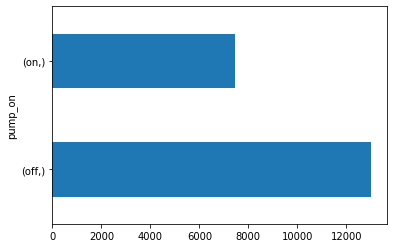

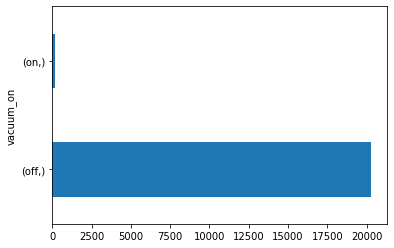

In [55]:
############################
## Descriptive Statistics ##
############################

## Divide into continuous and categorical
continuous_cols = data[["bvp", "bpm", "temp", "x", "y", "z"]]
categorical_cols = data[["pump_on", "vacuum_on"]]
categorical_cols = categorical_cols.replace({0.0: "off", 1.0: "on"})

## Continuous column stat
num_nan_cont = continuous_cols.isna().sum()
descriptive_stats_cont = continuous_cols.describe()
kurt = continuous_cols.kurtosis()
skew = continuous_cols.skew()

# boxplots for each column
for column in continuous_cols:
    figure = plt.figure()
    boxplot = continuous_cols[[column]].boxplot()
    figure.savefig("plots/" + PARTICIPANT + "_boxplot_" + column + ".svg", format="svg")

# histograms for each column
for column in continuous_cols:
    ##Freedman-Diaconis Bin Size
    q25 = continuous_cols[column].quantile(0.25)
    q75 = continuous_cols[column].quantile(0.75)
    max = continuous_cols[column].max()
    min = continuous_cols[column].min()
    num = len(continuous_cols)
    bin_width = (2*(q75 - q25)) /(num**(1/3))
    num_bins = math.ceil((max - min) / bin_width)
    figure = plt.figure()
    hist = continuous_cols[[column]].hist(bins=num_bins)
    figure.savefig("plots/" + PARTICIPANT + "_hist_" + column + ".svg", format="svg")


## Categorical column stats
num_nan_cat = categorical_cols.isna().sum()
descriptive_stats_cat = categorical_cols.describe()
value_counts  = categorical_cols.value_counts()
# add percentage of time pump on - just simple division with length of df and the value counts
# add percentage of time vacuum on - same as above

for column in categorical_cols:
    figure = plt.figure()
    bar_graph = categorical_cols[[column]].value_counts().plot(kind="barh")
    figure.savefig("plots/" + PARTICIPANT + "_bar_" + column + ".svg", format="svg")

num_pump_on = count_events(categorical_cols[['pump_on']])
num_vacuum_on = count_events(categorical_cols[['vacuum_on']])
# maybe extract lengths of pump time on and off

## there's a df.bivariate analysis function, do it for each of the columns pairwise
## repeat for categorical with it's specific stats


## remove outliers shown on boxplots
## remove first 5% and last 5%

## export all of this to a .txt file as a report (pX_report.txt)
## figure out how to best do this

In [ ]:
#######################
## Train Test Splits ##
#######################

## figure out a bunch of different train testing split percentages

## add to a list to iterate over so that you can use them in the next part

In [ ]:
#################
## Data Mining ##
#################

## go over what you want to do, keep it as simple as possible and only go more intense if you need to
## maybe you can pull in size of model - want to keep it small if it needs to go on board
## get training time for each model, could use this as motivation for customization for each person, since a short amount of time means we could do it on device or some shit like that 